# Meta-config generation for synthetic data

We will generate synthetic data configurations that can in turn generate synthetic data. The entire process is coded in a reproducible manner. This is useful for testing the pipeline. In the working directory, there are directories that are named by the number of covariates.
In each of the directories, we will generate a set of configurations that generate causal graphs with that number of covariates. The functional form of the covariate is one of the following:

1. With Parametric Assumptions: These set of Data Generating Processes have parametric Assumptions and are fast. it is categorized under the following:
    1. The function $t$ is non-linear:
        1. $t(x) = x^3$
        2. $t(x) = x + sin(x)$
    2. The function $t$ is linear
3. Non-linear Gaussian datasets with no parametric assumptions

We will explain in detail how we generate each of these datasets. The causal graph generators are separate entities and we will sample from three different causal graph types:

1. Chains (only one correct ordering and really sparse)
2. V-Structures (Many correct orderings and sparse) - one weired covariate and n-1 normal covariates
3. Forks (Many correct orderings and sparse) - one normal covariate and n-1 weired covariates
4. Erdos-Renyi (Many correct orderings and dense) with p set to 0.65
5. Full (one one correct ordering and dense)


In [13]:
import numpy as np

def generate_graph_generator_args(n: int):
    # graph generator
    graph_generator_args = {'n': n, 'seed': np.random.randint(1000)}
    type_ind = np.random.randint(5)
    if type_ind == 0 or n <= 2:
        graph_generator_args['graph_type'] = 'chain'
    elif type_ind == 1:
        graph_generator_args['graph_type'] = 'fork' if np.random.randint(2) else 'v_structure'
    elif type_ind == 2:
        graph_generator_args['graph_type'] = 'full'
    elif type_ind == 3:
        graph_generator_args['graph_type'] = 'erdos_renyi'
        graph_generator_args['p'] = 0.65
    else:
        graph_generator_args['graph_type'] = 'fork'
    
    return graph_generator_args

In [14]:
def get_conf(scm_generator, scm_generator_args, observation_size, conf_name):
    dataset_args = {
        'seed': np.random.randint(1000),
        'scm_generator': scm_generator,
        'scm_generator_args': scm_generator_args,
        'observation_size': observation_size,
        'name': conf_name,
    }

    conf = {
        'class_path': 'lightning_toolbox.DataModule',
        'init_args': {
            'dataset': 'ocd.data.SyntheticOCDDataset',
            'dataset_args': dataset_args,
            'val_size': 0.1,
            'batch_size': 128,
        },
    }
    
    return conf

Set the following for reproducibility and some pre-requisite imports.

In [15]:
import typing as th
from ruamel import yaml
import os
np.random.seed(100)

## Parametric datasets

In this set, the linking functions are random linear combinations of their parents with a non-linear transformation applied to them. The non-linear transformation is either a polynomial of degree 3 or $x + sin(x)$. The noise is sampled from a Gaussian distribution. The following cell defines the function that generates the configurations.

In [20]:

s_softplus = """def func(x):
    x[x < 100] = numpy.log(1 + numpy.exp(x[x < 100]))
    return x"""
    
s_return_1 = """def func(x):
    return numpy.ones_like(x)"""
    
def t_cube_dislocate(t):
    return f"""def func(x):
    x[x > 100] = 100
    x[x < -100] = -100
    x_mean = numpy.mean(x)
    x_std = numpy.std(x)
    if x_std == 0:
        x_std = 1
    x = (x - x_mean) / x_std
    ret = x**3 + {t}
    return ret"""

def t_sin_plus_x():
    return f"""def func(x):
    return numpy.sin(x) + x"""

def t_identity():
    return f"""def func(x):
    return x"""
    
def non_linear_gaussan_configurations(n_cov: th.List[int],
                                      n_configs: th.List[int],
                                      observation_sizes: th.List[int]):
    """
    This function generates a set of yaml files that contain the meta-data required to generate the synthetic data.
    The files are formatted as follows:
    
    >> parametric_non_linear_gaussian_{n_cov}_{observation_size}_{graph_type}_{type}.yaml
    
    type: sin_plus_x or x_cubed_plus_t
    
    For more information check out ocd/data/synthetic/non_linear_invertible_gaussian_scm_generator.py
    Args:
        n_cov: A list where n_cov[i] indicates the number of covariates in the ith set of configurations
        n_configs: A list where n_configs[i] indicates the number of configurations to generate for the ith set of configurations
        observation_sizes: A list where 
        observation_sizes[i] indicates the number of observations to generate for the ith set of configurations
    """
      
    for n, observation_size, n_config in zip(n_cov, observation_sizes, n_configs):
        for _ in range(n_config):
            
            scm_generator_args = {}
            scm_generator_args['graph_generator'] = 'ocd.data.scm.GraphGenerator'
            scm_generator_args['graph_generator_args'] = generate_graph_generator_args(n)    
            
            scm_generator_args['seed'] = np.random.randint(1000)
            
            idx = np.random.randint(3)
            
            if idx == 0:
                scm_generator_args['noise_type'] = "normal"
                scm_generator_args['noise_parameters'] = {
                    'scale': 1.0,
                    'loc': 0.0
                }
            elif idx == 1:
                scm_generator_args['noise_type'] = "laplace"
                scm_generator_args['noise_parameters'] = {
                    'scale': 1.0,
                    'loc': 0.0
                }
            else:
                scm_generator_args['noise_type'] = "uniform"
                scm_generator_args['noise_parameters'] = {
                    'high': 1.0,
                    'low': 0.0
                }
                
            scm_generator = 'ocd.data.synthetic.ParametricSCMGenerator'
            
            
            scm_generator_args['seed'] = np.random.randint(1000)
            scm_generator_args['weight_s'] = [0.5, 1.5]
            scm_generator_args['weight_t'] = [0.5, 1.5]
            
            
            type = np.random.randint(2)
            if type == 0:
                s_func = s_softplus
                s_desc = 'modulated'
                scm_generator_args['s_function_signature'] = 'softplus'
            elif type == 1:
                s_func = s_return_1
                s_desc = 'anm'
                scm_generator_args['s_function_signature'] = 'ret1'
                
            scm_generator_args['s_function'] = {
                'function_descriptor': s_func,
                'function_of_interest': 'func'
            }
            
            type = np.random.randint(3)
            
            if type == 0:
                # Cube and dislocate function
                type_naming = 'cube_dislocate'
                scm_generator_args['t_function'] = {
                    'function_descriptor': t_cube_dislocate(np.random.randint(10)),
                    'function_of_interest': 'func'
                }
                scm_generator_args['t_function_signature'] = 'cube_and_dislocate'
            elif type == 1:
                # Sine function
                type_naming = 'sin_plus_x'
                scm_generator_args['t_function'] = {
                    'function_descriptor': t_sin_plus_x(),
                    'function_of_interest': 'func'
                }
                scm_generator_args['t_function_signature'] = 'sin_plus_x'
            else:
                # Identity function
                type_naming = 'linear'
                scm_generator_args['t_function'] = {
                    'function_descriptor': t_identity(),
                    'function_of_interest': 'func'
                }
                scm_generator_args['t_function_signature'] = 'identity'
                

            scm_generator = 'ocd.data.synthetic.ParametricSCMGenerator'
            conf_name = f"parametric_{scm_generator_args['noise_type']}_{s_desc}_{n}_{observation_size}_{scm_generator_args['graph_generator_args']['graph_type']}_{type_naming}"
            
            conf = get_conf(scm_generator, scm_generator_args, observation_size, conf_name)
            
            
            # write conf to conf_name in yaml format
            with open(os.path.join('synthetic', f"{conf_name}.yaml"), 'w') as f:
                # yaml.dump(conf, f)
                yaml.safe_dump(conf, f, indent=4)
                

            

To generate the meta-data for the configurations run the following block. These data have larger `observation_size`.

In [21]:
np.random.seed(100)
ns = [2, 3, 4, 5, 10, 25, 50, 100]
n_configs = [40, 40, 40, 40, 40, 40, 40, 40]
observation_size = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

non_linear_gaussan_configurations(ns, n_configs, observation_size)

## Non-parametric generators with Gaussian Processes



In the following, we can generate the linking functions by sampling from a Gaussian Process. The function that is sampled from the Gaussian process is most likely invertible and non-linear.

In [22]:

s_func = """def func(x):
    x[x < 100] = numpy.log(1 + numpy.exp(x[x < 100]))
    return x"""

t_func = """def func(x):
    return numpy.sin(x) + x"""   
    
def non_parametric_gaussian_process_generator(
                                    n_cov: th.List[int],
                                    n_configs: th.List[int],
                                    observation_sizes: th.List[int]):
    """
    This function generates a set of yaml files that contain the meta-data required to generate the synthetic data.
    The files are formatted as follows:
    
    >> non_parametric_non_linear_gaussian_{n_cov}_{observation_size}_{graph_type}.yaml
    
    For more information check out ocd/data/synthetic/gaussian_process.py
    
    Args:
        n_cov: A list where n_cov[i] indicates the number of covariates in the ith set of configurations
        n_configs: A list where n_configs[i] indicates the number of configurations to generate for the ith set of configurations
        observation_sizes: A list where 
        observation_sizes[i] indicates the number of observations to generate for the ith set of configurations
    """
      
    for n, observation_size, n_config in zip(n_cov, observation_sizes, n_configs):
        for _ in range(n_config):
            
            scm_generator_args = {}
            scm_generator_args['graph_generator'] = 'ocd.data.scm.GraphGenerator'
            scm_generator_args['graph_generator_args'] = generate_graph_generator_args(n)    
            

            scm_generator_args['seed'] = np.random.randint(1000)
            scm_generator_args['noise_std'] = 1.0
            scm_generator_args['noise_mean'] = 0.0
            scm_generator_args['s_gamma_rbf_kernel'] = 1.0
            scm_generator_args['s_variance_rbf_kernel'] = 1.0
            scm_generator_args['s_mean_function_weights'] = [0.01, 0.1]
            scm_generator_args['s_mean_function_activation'] = {
                'function_descriptor': s_func,
                'function_of_interest': 'func'
            }
            scm_generator_args['s_mean_function_activation_signature'] = 'softplus'
            
            scm_generator_args['t_variance_rbf_kernel'] = 1.0
            scm_generator_args['t_mean_function_weights'] = [0.01, 0.1]
            
            scm_generator_args['t_mean_function_activation'] = {
                'function_descriptor': t_func,
                'function_of_interest': 'func',
            }
            scm_generator_args['t_mean_function_activation_signature'] = 'sin_plus_x'
            
            scm_generator = 'ocd.data.synthetic.GaussianProcessBasedSCMGeberator'
            conf_name = f"non_parametric_non_linear_gaussian_{n}_{observation_size}_{scm_generator_args['graph_generator_args']['graph_type']}"
            
            conf = get_conf(scm_generator, scm_generator_args, observation_size, conf_name)
            
            
            # write conf to conf_name in yaml format
            with open(os.path.join('synthetic', f"{conf_name}.yaml"), 'w') as f:
                # yaml.dump(conf, f)
                yaml.safe_dump(conf, f, indent=4)
                

            

To generate the meta-data for the configurations run the following block. These data have smaller `observation_size` because it is computationally expensive to generate them.

In [23]:
np.random.seed(100)

ns = [2, 3, 4, 5, 10, 25, 50, 100]
n_configs = [40, 40, 40, 40, 40, 40, 40, 40]
observation_size = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

non_parametric_gaussian_process_generator(ns, n_configs, observation_size)

## Testing it

Let's load a one of the synthetic data configurations and generate the data.

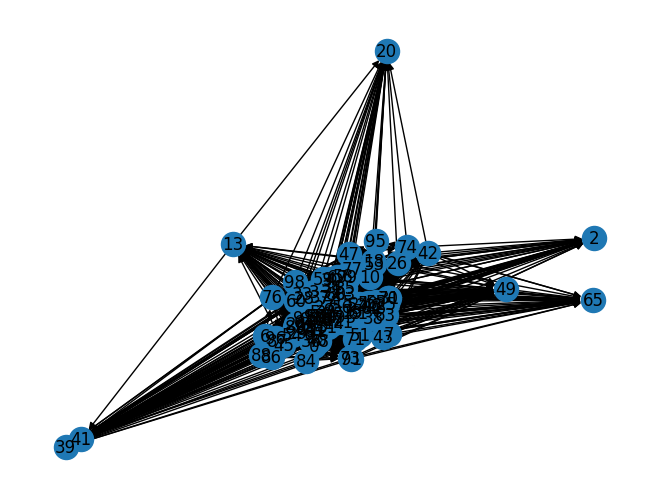

x(23) = sin_plus_x(+1.05) + softplus(+1.46) * N(0.00,1.00)
---------------------
x(48) = sin_plus_x(+1.32) + softplus(+1.29) * N(0.00,1.00)
---------------------
x(97) = sin_plus_x(+0.79) + softplus(+1.04) * N(0.00,1.00)
---------------------
x(9) = sin_plus_x(x(23)*1.18+1.11) + softplus(x(23)*0.56+1.08) * N(0.00,1.00)
---------------------
x(62) = sin_plus_x(x(23)*0.92+x(48)*0.60+0.63) + softplus(x(23)*1.04+x(48)*1.24+1.08) * N(0.00,1.00)
---------------------
x(85) = sin_plus_x(x(23)*0.57+x(48)*0.81+1.49) + softplus(x(23)*0.77+x(48)*0.63+0.74) * N(0.00,1.00)
---------------------
x(90) = sin_plus_x(x(48)*1.02+x(9)*0.71+1.19) + softplus(x(48)*1.30+x(9)*0.77+0.99) * N(0.00,1.00)
---------------------
x(80) = sin_plus_x(x(23)*0.83+x(48)*0.65+x(97)*0.53+x(62)*1.43+1.28) + softplus(x(23)*0.85+x(48)*1.39+x(97)*0.75+x(62)*1.02+1.08) * N(0.00,1.00)
---------------------
x(35) = sin_plus_x(x(62)*1.41+x(9)*0.98+0.79) + softplus(x(62)*0.61+x(9)*1.41+0.60) * N(0.00,1.00)
---------------------
x(

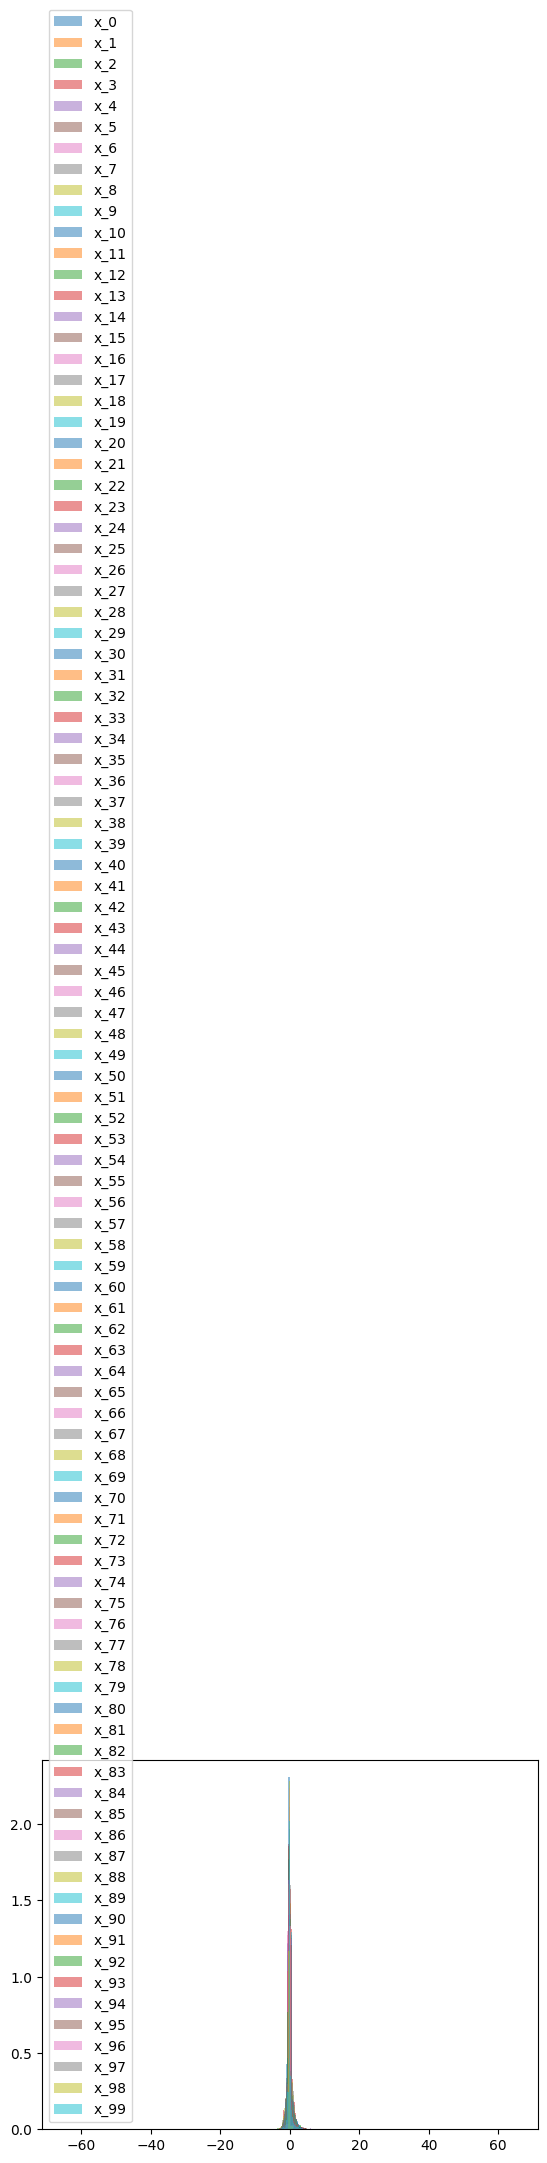

In [11]:
from lightning_toolbox import DataModule
import yaml
import networkx as nx
import matplotlib.pyplot as plt
import sys

sys.path.append('../..')
# filename
filename = 'cherry-picked-synthetic/parametric_non_linear_gaussian_100_5000_erdos_renyi_sin_plus_x.yaml'

# load config into dictionary
with open(filename, 'r') as f:
    conf = yaml.safe_load(f)
dm = DataModule(**conf['init_args'])

dm.setup('fit')

nx.draw(dm.data.dag, with_labels=True)
plt.show()
print(dm.data.explanation)
for c in dm.data.samples.columns:
    plt.hist(dm.data.samples[c], density=True, bins=100, alpha=0.5, label=f"x_{c}")

plt.legend()
plt.show()
